# 01 — Загрузка данных EUR/USD из OANDA

Загружаем конфиг OANDA, подключаемся к v20 REST API, скачиваем свечи EUR/USD для M15 и H1,
сохраняем данные в data/ и строим простой график для проверки.

In [1]:
import logging
from datetime import datetime, timezone
from pathlib import Path
import sys

from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd

PROJECT_ROOT = Path.cwd().resolve()
if (PROJECT_ROOT / "src").exists():
    ROOT = PROJECT_ROOT
elif (PROJECT_ROOT.parent / "src").exists():
    ROOT = PROJECT_ROOT.parent
else:
    ROOT = PROJECT_ROOT

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.oanda_client import OandaClient, OandaConfig

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

DATA_DIR = ROOT / "data"
CONFIG_PATH = ROOT / "config" / "oanda_config.json"
if not CONFIG_PATH.exists():
    CONFIG_PATH = ROOT / "config" / "oanda_config.example.json"

DATA_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
config = OandaConfig.from_json(CONFIG_PATH)
client = OandaClient(config=config)

print(f"Base URL: {config.base_url}")


Base URL: https://api-fxpractice.oanda.com


In [3]:
account_details = client.get_account_details()
account_details


{'account': {'guaranteedStopLossOrderMode': 'ALLOWED',
  'hedgingEnabled': False,
  'id': '101-004-37622601-001',
  'createdTime': '2025-11-09T10:55:46.934444611Z',
  'currency': 'GBP',
  'createdByUserID': 37622601,
  'alias': 'Primary',
  'marginRate': '0.03333333333333',
  'lastTransactionID': '3',
  'balance': '100000.0000',
  'openTradeCount': 0,
  'openPositionCount': 0,
  'pendingOrderCount': 0,
  'pl': '0.0000',
  'resettablePL': '0.0000',
  'resettablePLTime': '0',
  'financing': '0.0000',
  'commission': '0.0000',
  'dividendAdjustment': '0',
  'guaranteedExecutionFees': '0.0000',
  'orders': [],
  'positions': [],
  'trades': [],
  'trueUnrealizedPL': '0.0000',
  'unrealizedPL': '0.0000',
  'trueNAV': '100000.0000',
  'NAV': '100000.0000',
  'marginUsed': '0.0000',
  'marginAvailable': '100000.0000',
  'positionValue': '0.0000',
  'marginCloseoutUnrealizedPL': '0.0000',
  'marginCloseoutNAV': '100000.0000',
  'marginCloseoutMarginUsed': '0.0000',
  'marginCloseoutPositionVal

По умолчанию скачиваем ~24 месяца истории. При необходимости можно переключиться на быстрый
режим с ограниченным количеством свечей.

In [4]:
INSTRUMENT = "EUR_USD"
USE_RANGE = True

if USE_RANGE:
    end_dt = datetime.now(timezone.utc).replace(minute=0, second=0, microsecond=0)
    start_dt = end_dt - relativedelta(months=24)

    eurusd_m15 = client.get_candles_range(INSTRUMENT, "M15", start=start_dt, end=end_dt)
    eurusd_h1 = client.get_candles_range(INSTRUMENT, "H1", start=start_dt, end=end_dt)
else:
    eurusd_m15 = client.get_candles(INSTRUMENT, "M15", count=5000)
    eurusd_h1 = client.get_candles(INSTRUMENT, "H1", count=5000)


INFO: Fetching EUR_USD M15 from 2023-12-20T13:00:00Z (max 5000)
INFO: Fetching EUR_USD M15 from 2024-03-05T14:45:01Z (max 5000)
INFO: Fetching EUR_USD M15 from 2024-05-16T15:30:01Z (max 5000)
INFO: Fetching EUR_USD M15 from 2024-07-29T20:00:01Z (max 5000)
INFO: Fetching EUR_USD M15 from 2024-10-09T21:45:01Z (max 5000)
INFO: Fetching EUR_USD M15 from 2024-12-23T00:30:01Z (max 5000)
INFO: Fetching EUR_USD M15 from 2025-03-07T02:15:01Z (max 5000)
INFO: Fetching EUR_USD M15 from 2025-05-20T03:00:01Z (max 5000)
INFO: Fetching EUR_USD M15 from 2025-07-31T04:45:01Z (max 5000)
INFO: Fetching EUR_USD M15 from 2025-10-13T06:30:01Z (max 5000)
INFO: Fetching EUR_USD M15 from 2025-12-19T21:45:01Z (max 5000)
INFO: Fetching EUR_USD H1 from 2023-12-20T13:00:00Z (max 5000)
INFO: Fetching EUR_USD H1 from 2024-10-09T21:00:01Z (max 5000)
INFO: Fetching EUR_USD H1 from 2025-07-31T04:00:01Z (max 5000)
INFO: Fetching EUR_USD H1 from 2025-12-19T21:00:01Z (max 5000)


In [5]:
print("M15:", eurusd_m15.shape, eurusd_m15["time"].min(), eurusd_m15["time"].max())
print("H1 :", eurusd_h1.shape, eurusd_h1["time"].min(), eurusd_h1["time"].max())
print("M15 duplicates:", eurusd_m15["time"].duplicated().sum())
print("H1 duplicates :", eurusd_h1["time"].duplicated().sum())


M15: (49753, 6) 2023-12-20 13:00:00+00:00 2025-12-19 21:45:00+00:00
H1 : (12439, 6) 2023-12-20 13:00:00+00:00 2025-12-19 21:00:00+00:00
M15 duplicates: 0
H1 duplicates : 0


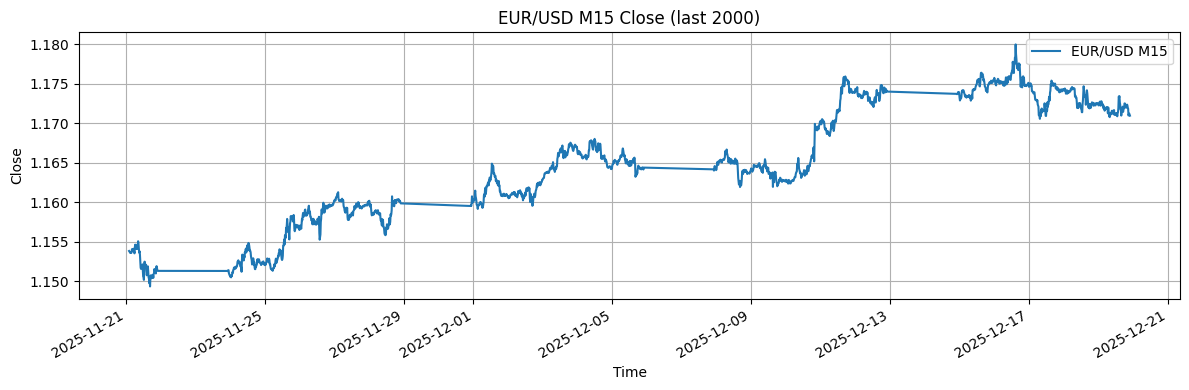

In [6]:
plt.figure(figsize=(12, 4))
eurusd_m15.tail(2000).plot(x="time", y="close", ax=plt.gca(), label="EUR/USD M15")
plt.title("EUR/USD M15 Close (last 2000)")
plt.xlabel("Time")
plt.ylabel("Close")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
m15_path = DATA_DIR / "eurusd_M15.parquet"
h1_path = DATA_DIR / "eurusd_H1.parquet"

eurusd_m15.to_parquet(m15_path, index=False)
eurusd_h1.to_parquet(h1_path, index=False)

print(f"Saved M15 to: {m15_path}")
print(f"Saved H1 to: {h1_path}")


Saved M15 to: /Users/oleksandrpc/Desktop/my projects/EUR_USD_MODEL/data/eurusd_M15.parquet
Saved H1 to: /Users/oleksandrpc/Desktop/my projects/EUR_USD_MODEL/data/eurusd_H1.parquet
